In [91]:
# Import useful packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime
import numpy as np
#import cftime
import pyproj
from dask.diagnostics import ProgressBar

## Import Satellite SIC data

In [73]:

#with ProgressBar():
ds = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [74]:
ds

<xarray.Dataset>
Dimensions:              (time: 5964, x: 1216, y: 1792)
Coordinates:
  * x                    (x) float64 -3.847e+06 -3.841e+06 ... 3.747e+06
  * y                    (y) float64 -5.347e+06 -5.341e+06 ... 5.847e+06
  * time                 (time) datetime64[ns] 2002-06-01 ... 2019-12-31
Data variables:
    polar_stereographic  (time) |S1 dask.array<chunksize=(30,), meta=np.ndarray>
    z                    (time, y, x) float32 dask.array<chunksize=(30, 1792, 1216), meta=np.ndarray>
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Sun Jun 21 02:48:54 2020: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSRE sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

## Convert co-ordinated from x,y to lat,lon

In [76]:
# Output coordinates are in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')

# Input coordinates are in meters on the Polar Stereographic 
# projection given in the netCDF file
projIn = pyproj.Proj(init='epsg:3411',
    preserve_units=True)

xx, yy = np.meshgrid( ds.x.values, ds.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
ds['lon'] = (('y','x'),lon)
ds['lat'] = (('y','x'),lat)
ds

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_887/3111021528.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.tr

<xarray.Dataset>
Dimensions:              (time: 5964, x: 1216, y: 1792)
Coordinates:
  * x                    (x) float64 -3.847e+06 -3.841e+06 ... 3.747e+06
  * y                    (y) float64 -5.347e+06 -5.341e+06 ... 5.847e+06
  * time                 (time) datetime64[ns] 2002-06-01 ... 2019-12-31
Data variables:
    polar_stereographic  (time) |S1 dask.array<chunksize=(30,), meta=np.ndarray>
    z                    (time, y, x) float32 dask.array<chunksize=(30, 1792, 1216), meta=np.ndarray>
    lon                  (y, x) float64 -80.73 -80.69 -80.65 ... 102.4 102.3
    lat                  (y, x) float64 33.96 33.98 34.01 ... 31.44 31.42 31.4
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Sun Jun 21 02:48:54 2020: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSRE sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

## Select the Greenland Sea area

In [77]:
GLarea = ds.where((ds.lon>=-10) & (ds.lon<=10) & (ds.lat <=85 )  & (ds.lat >= 70),drop = True)

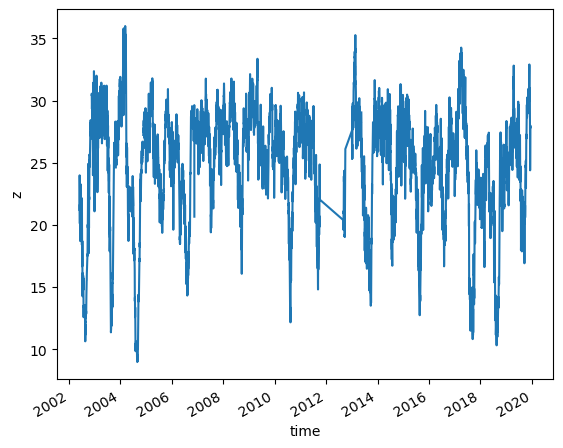

In [78]:
# Plot daily data over all years
GLarea['z'].sel(time = slice('2002-06-01','2019-12-12')).mean(("x","y")).plot()

## Create monthly means for 20 years

In [79]:
si_monthly = GLarea.z.groupby('time.month').mean(dim = ["time"],keep_attrs=True)

[###                                     ] | 8% Completed | 14.70 sms

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


[########################################] | 100% Completed | 159.98 s


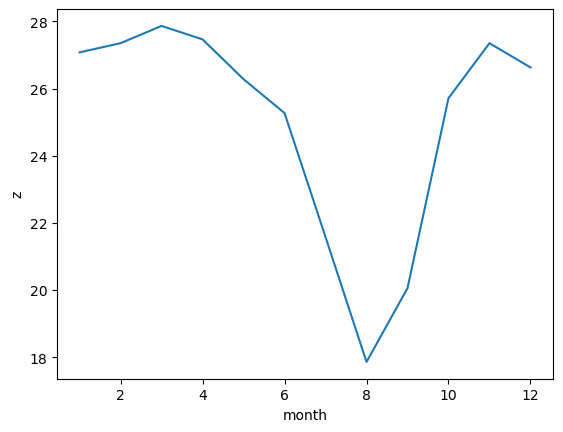

In [81]:
with ProgressBar():
    si_monthly.mean(("x","y")).plot()

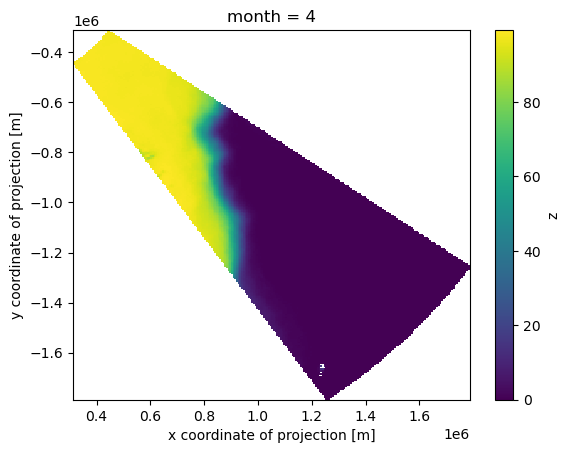

In [88]:
si_monthly[3].plot.pcolormesh()

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


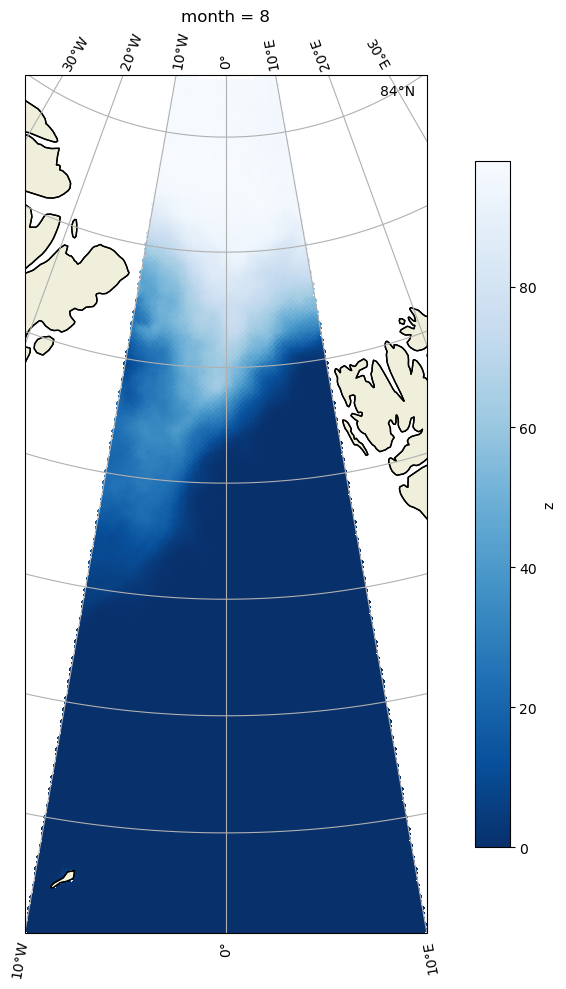

In [93]:
extent = [-10,10, 85, 70]
fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.NorthPolarStereo()})
#fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.epsg(3411)})

si_monthly.sel(month = 8).plot.pcolormesh(
    ax = ax,
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
    # transform=ccrs.PlateCarree(),
    transform=ccrs.epsg(3411),
    cmap=plt.colormaps['Blues_r']
    # levels=10,
        )
ax.set_extent(extent, ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
fig.tight_layout()

In [84]:
with ProgressBar():
    si_monthly.to_netcdf("monthlymean_GLsea_SIC_AMSR2/E_2002-2019.nc")

PermissionError: [Errno 13] Permission denied: b'/home/jovyan/Tjaernoe2022-group4/notebooks/Jessica/monthlymean_GLsea_SIC_AMSR2/E_2002-2019.nc'